In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output
import torch

torch.cuda.is_available()

True

In [4]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/hybrid2.pth')
hybrid_model.cuda()

MatchingModel(
  (attr_summarizers): ModuleMap(
    (Song_Name): Hybrid(
      (word_contextualizer): RNN(
        (rnn_groups): ModuleList(
          (0): GRU(300, 150, batch_first=True, bidirectional=True)
        )
        (dropouts): ModuleList(
          (0): Dropout(p=0)
        )
        (bypass_networks): ModuleList(
          (0): None
        )
        (input_dropout): NoMeta(
          (module): Dropout(p=0)
        )
      )
      (word_comparator): Attention(
        (alignment_networks): ModuleList(
          (0): AlignmentNetwork(
            (transform): Transform(
              (transforms): ModuleList(
                (0): Linear(in_features=300, out_features=300, bias=True)
                (1): Linear(in_features=300, out_features=300, bias=True)
              )
              (bypass_networks): ModuleList(
                (0): Bypass(
                  (highway_gate): Linear(in_features=300, out_features=300, bias=True)
                )
                (1): Bypass(


## Datasets creation

In [5]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [6]:
testneg_classifier_inputs,testneg_classifier_outputs,testneg_ids = return_layer_input_output('../../Structured/itunes-amazon/'
                                                                         ,'test_negatives',32,hybrid_model,
                                                                        hybrid_model.classifier)

In [6]:
neg_classifier_inputs,neg_classifier_outputs,neg_ids = return_layer_input_output('../../Structured/itunes-amazon/exp3'
                                                                         ,'negatives',32,hybrid_model,
                                                                        hybrid_model.classifier)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:58

In [8]:
testpos_classifier_inputs,testpos_classifier_outputs,testpos_ids = return_layer_input_output('../../Structured/itunes-amazon/',
                                                                       'test_positives',32,hybrid_model,
                                                                       hybrid_model.classifier)

In [9]:
pos_classifier_inputs,pos_classifier_outputs,pos_ids = return_layer_input_output('../../Structured/itunes-amazon/exp3',
                                                                       'positives',32,hybrid_model,
                                                                       hybrid_model.classifier)

In [10]:
test_negative_classifier_inputs = list(map(lambda x: x[0],testneg_classifier_inputs))
test_positive_classifier_inputs = list(map(lambda x: x[0],testpos_classifier_inputs))
negative_classifier_inputs = list(map(lambda x: x[0],neg_classifier_inputs))
positive_classifier_inputs = list(map(lambda x: x[0],pos_classifier_inputs))

## Utility methods

In [11]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change

## Negative sample analysis

In [12]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in test_negative_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1),attributes))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

In [13]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [14]:
import pandas as pd
variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)

In [15]:
ri_sums = variation_df.sum(numeric_only=True)

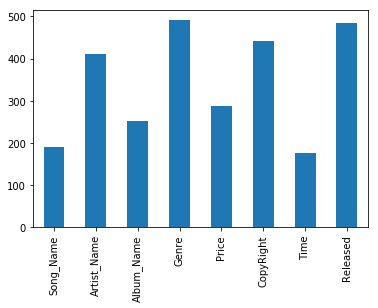

In [17]:
ri_sums.plot.bar()

In [28]:
variation_df.to_csv('../../experiments-results/exp3/testnegatives_ri.csv',index=False)

## Positive samples analisys

In [18]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in test_positive_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0),attributes))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30


In [19]:
ri_norms = []
for ri_list in positives_ri_matrix:
    ri_norms.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [20]:
import pandas as pd
variation_df = pd.DataFrame(data= ri_norms,columns=attributes)
variation_df.head(10)

,Song_Name,Artist_Name,Album_Name,Genre,Price,CopyRight,Time,Released
0,6.847384,19.544884,9.933538,19.183775,9.573101,21.059700,6.517508,21.275204
1,8.989816,21.562540,10.841571,20.665524,10.330796,22.093853,8.451209,22.889296
2,0.962359,2.197567,1.275658,2.540286,1.288801,2.866425,0.937564,2.952036
3,3.674964,8.306692,4.742630,13.100067,4.162773,9.804399,3.131742,12.881296
4,3.464167,8.105570,4.613362,9.318472,4.773021,11.212422,3.409914,11.627936
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.966254,2.180108,1.275622,2.472721,1.352569,2.932230,0.973949,3.057708
7,6.977536,15.264844,9.227065,16.219580,7.583784,16.910307,5.630791,15.695223
8,5.835146,15.844918,7.549815,17.024902,6.384524,18.484629,4.878843,17.398010
9,2.295998,5.134629,3.125388,6.178668,2.816319,5.796661,1.918581,5.880469


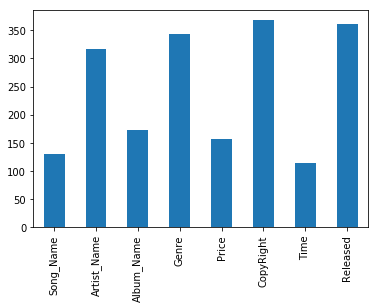

In [21]:
ri_sums = variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [33]:
variation_df.to_csv('../../experiments-results/exp3/testpositives_ri.csv',index=False)

## Finding closer vectors

In [22]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [23]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in test_negative_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri_matrix[i][attributes.index(att)]
                                                                ,positive_classifier_inputs,attributes.index(att),
                                                                150,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [24]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in test_positive_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri_matrix[i][attributes.index(att)]
                                                                ,negative_classifier_inputs,attributes.index(att),
                                                                150,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [25]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])

In [26]:
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c: pos_ids[c])

In [61]:
def find_common_elements(l):
    res = set(l[0])
    for s in l[1:]:
        res.intersection_update(s)
    return res

In [44]:
negatives = pd.read_csv('../../Structured/itunes-amazon/exp3/negatives.csv')
positives = pd.read_csv('../../Structured/itunes-amazon/exp3/positives.csv')

### Analyze nearest neighbours on Album

In [45]:
nn_onAlbum = pd.merge(positives_closer_vectors_df,negatives,left_on='Album_Name',right_on='id')

In [48]:
nn_onAlbum[['ltable_Album_Name','rtable_Album_Name']].head(30)

,ltable_Album_Name,rtable_Album_Name
0,Listen ( Deluxe Version ),Listen
1,Listen ( Deluxe Version ),Listen
2,Listen ( Deluxe Version ),Listen
3,Listen ( Deluxe Version ),Listen
4,Listen ( Deluxe Version ),Listen
5,Listen ( Deluxe Version ),Listen
6,Listen ( Deluxe Version ),Listen
7,Listen ( Deluxe Version ),Listen
8,Listen ( Deluxe Version ),Listen
9,Listen ( Deluxe Version ),Listen


### Analyze nearest neighbours on artist name

In [49]:
nn_onArtist = pd.merge(positives_closer_vectors_df,negatives,left_on='Artist_Name',right_on='id')

In [50]:
nn_onArtist[['ltable_Artist_Name','rtable_Artist_Name']].head(30)

,ltable_Artist_Name,rtable_Artist_Name
0,Wiz Khalifa,Wiz Khalifa
1,Wiz Khalifa,Wiz Khalifa
2,Wiz Khalifa,Wiz Khalifa
3,Wiz Khalifa,Wiz Khalifa
4,Wiz Khalifa,Wiz Khalifa
5,Wiz Khalifa,Wiz Khalifa
6,Wiz Khalifa,Wiz Khalifa
7,Wiz Khalifa,Wiz Khalifa
8,Wiz Khalifa,Wiz Khalifa
9,Wiz Khalifa,Wiz Khalifa


### Nearest Neighbours on Time

In [33]:
nearest_neighbours_onTime = pd.merge(negatives_closer_vectors_df,positives,left_on='Time',right_on='id')

In [43]:
nearest_neighbours_onTime['rtable_Time'].unique()

array(['3:15', '4:56', '4:02', '3:20', '3:26', '3:31', '3:12', '3:41',
       '3:44', '3:40', '3:25', '4:39', '3:38', '3:56', '3:45', '6:25',
       '3:28', '3:11'], dtype=object)

In [ ]:
it,variation = find_smallest_variation_to_change(hybrid_model.classifier,positive_classifier_inputs[0],20,6,0)

In [ ]:
positive_classifier_inputs[0][20].data = positive_classifier_inputs[0][20].data.copy_(positive_classifier_inputs[0][20].data+
                                                                                     variation.data)

In [ ]:
hybrid_model.classifier.forward(positive_classifier_inputs[0])[20]

In [ ]:
grads_list = []
h = positive_classifier_inputs[0].register_hook(lambda g: grads_list.append(g))

In [ ]:
out = hybrid_model.classifier.forward(positive_classifier_inputs[0])
prob = get_probabilites(out[20])

In [ ]:
from torch.autograd import Variable
true_labels = Variable (torch.cuda.FloatTensor([0,1]))